### Import required libraries

In [1]:
import mxnet as mx
import gluoncv as gcv
import matplotlib.pyplot as plt
import numpy as np

### Read the image

In [2]:
img = mx.image.imread('Data/dog.jpg')

### Information about image

In [3]:
print("Image Type:", type(img))
print("Image Shape:", img.shape)
print("Data Type:", img.dtype)
print("Min Value: {}, and Max Value: {}".format(img.min().asscalar(), img.max().asscalar()))

Image Type: <class 'mxnet.ndarray.ndarray.NDArray'>
Image Shape: (576, 768, 3)
Data Type: <class 'numpy.uint8'>
Min Value: 0, and Max Value: 255


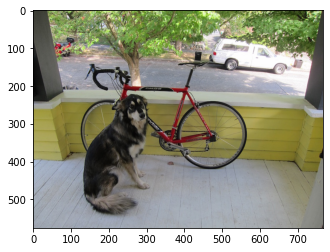

In [4]:
plt.imshow(img.asnumpy())

### Transform Image

In [5]:
from mxnet.gluon.data.vision import transforms

transform_fn = transforms.Compose([
    # the data layout of the image will be converted from HWC to CHW
    # Data type will be converted from 8-bit int to 32-bit float
    transforms.ToTensor(),
    # will normalize the values of the image using ImageNet one case statistics
    transforms.Normalize([.485, .456, .406], [.229, .224, .225])
])

In [6]:
image = transform_fn(img)

print("Image Type:", type(image))
print("Image Shape:", image.shape)
print("Data Type:", image.dtype)
print("Min Value: {:.3f}".format(image.min().asscalar()))
print('Max Value: {:.3f}'.format(image.max().asscalar()))

Image Type: <class 'mxnet.ndarray.ndarray.NDArray'>
Image Shape: (3, 576, 768)
Data Type: <class 'numpy.float32'>
Min Value: -2.118
Max Value: 2.640


### Batch Image

In [7]:
# expand_dims --> add extra dimension at the beginning
# 0 indicates that the new dimension will be added as the first dim
# Image will be in WCHW format
image = image.expand_dims(0)
print(image.shape)

(1, 3, 576, 768)


### Load Model

In [8]:
# fcn_resnet50_ade trained on ADE20K dataset
# model parameters are stored in .mxnet cash
ImSegModel = gcv.model_zoo.get_model('fcn_resnet50_ade', pretrained= True)

### Make prediction

In [9]:
output = ImSegModel.demo(image)
print(output.shape)

'''
(1, 150, 576, 768)
  - 1   --> We have only one image in the batch
  - 150 --> Their are 150 classes in ADE20K dataset
  - 576 --> Image height
  - 768 --> Image width
'''

(1, 150, 576, 768)


/home/shehata/.local/lib/python3.8/site-packages/gluoncv/model_zoo/segbase.py:107: UserWarning: demo method will be deprecated in favor of predict.
  warnings.warn('demo method will be deprecated in favor of predict.')


'\n(1, 150, 576, 768)\n  - 1   --> We have only one image in the batch\n  - 150 --> Their are 150 classes in ADE20K dataset\n  - 576 --> Image height\n  - 768 --> Image width\n'

In [10]:
output = output[0]
print(output.shape)

(150, 576, 768)


### Pixel Slice

In [11]:
px_height, px_width = 300, 500

px_logit = output[:, px_height, px_width]

In [12]:
# use softmax func to convert logits to probability
px_probability = mx.nd.softmax(px_logit)
px_rounded_probability = mx.nd.round(px_probability * 100) / 100
print(px_rounded_probability)


[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.96 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
<NDArray 150 @cpu(0)>


In [20]:
# argmax for finding the most likely class for this pixel
# after converting from mxnet float to python integer
# the class 127 is the most likely
class_index = mx.nd.argmax(px_logit, axis= 0)
class_index = class_index[0].astype('int').asscalar()
print(class_index)

127


### Class label

In [21]:
# Convert class index to class labels
from gluoncv.data.ade20k.segmentation import ADE20KSegmentation

class_label = ADE20KSegmentation.CLASSES[class_index]
print(class_label)

bicycle, bike, wheel, cycle


In [22]:
# axis= 0 corresponding to channel dimension which are the classes
# output is the probability distribution accross classes for every pixel
output_probability = mx.nd.softmax(output, axis= 0)

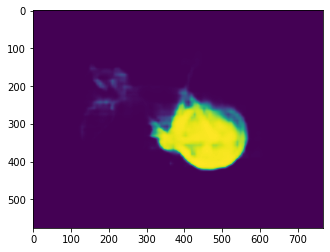

In [23]:
output_heatmap = output_probability[127]
plt.imshow(output_heatmap.asnumpy())

### Visualize most likely class

In [25]:
prediction = mx.nd.argmax(output, 0).asnumpy()
print(prediction.shape)

(576, 768)


In [26]:
print(prediction)

[[0. 0. 0. ... 4. 4. 4.]
 [0. 0. 0. ... 4. 4. 4.]
 [0. 0. 0. ... 4. 4. 4.]
 ...
 [3. 3. 3. ... 0. 0. 0.]
 [3. 3. 3. ... 0. 0. 0.]
 [3. 3. 3. ... 0. 0. 0.]]


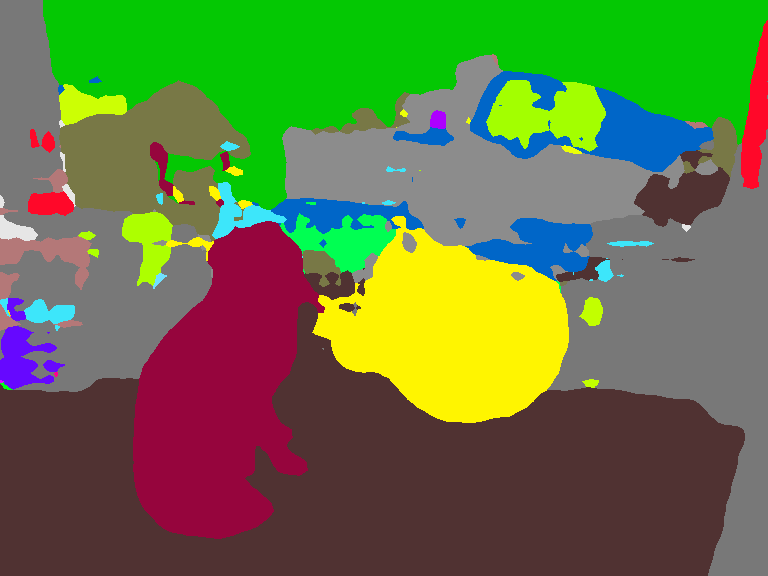

In [27]:
from gluoncv.utils.viz import get_color_pallete

prediction_image = get_color_pallete(prediction, 'ade20k')
prediction_image

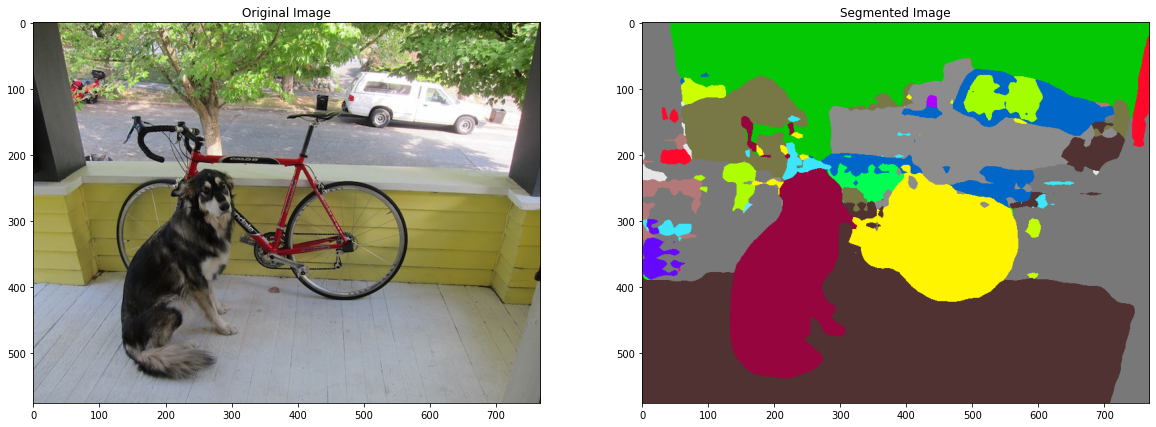

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.set_title('Original Image')
ax1.imshow(img.asnumpy())
ax2.set_title('Segmented Image')
ax2.imshow(prediction_image)